In [ ]:
!! pip install -U open-metric-learning

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




---

# MTCNN

In [ ]:
# !pip install facenet-pytorch

In [ ]:
# import os
# import cv2
# from facenet_pytorch import MTCNN

# mtcnn = MTCNN(image_size=224, margin=20, min_face_size=20)

# dataset_root = "/OML/img/pre_MAN"
# cropped_images_dir = "/OML/img/MAN"

# def transform_image_with_crop(image_path):
#     image = cv2.imread(image_path)
#     rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     boxes, _ = mtcnn.detect(rgb_image)
#     if boxes is not None:
#         for i, box in enumerate(boxes):
#             x_min, y_min, x_max, y_max = box
#             cropped_face = rgb_image[int(y_min):int(y_max), int(x_min):int(x_max)]
#             resized_face = cv2.resize(cropped_face, (800, 800), interpolation=cv2.INTER_AREA)
#             cv2.imwrite(os.path.join(cropped_images_dir, os.path.basename(image_path)), cv2.cvtColor(resized_face, cv2.COLOR_RGB2BGR))


# for filename in os.listdir(dataset_root):
#     if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
#         transform_image_with_crop(os.path.join(dataset_root, filename))



---
# DF 생성


In [ ]:
# import os
# os.chdir("/OML/img/MAN")

# # path
# fpath = os.listdir()
# path = sorted(fpath)

# # label
# n = 0
# label = []
# for i in path:
#   fst = [word[0] for word in path]
#   for letter in fst:
#     if letter == fst[0]:
#       label.append(n)
#     else:
#       break
#   n += 1

#   if len(label) >= len(path):
#     break

In [ ]:
# # split
# split = ["train" for _ in label]
# idx = int(len(label) * 0.5)

# while(True):
#   if label[idx] == label[idx - 1] and label[idx] == label[idx + 1]:
#     idx += 1

#   elif label[idx] == label[idx - 1]:
#     idx += 1

#   else: break


# for i in range(idx,len(split)):
#   split[i] = "validation"

In [ ]:
# # is_query, is_gallery
# import numpy as np
# is_query = ['NaN' for _ in label]
# is_gallery = ['NaN' for _ in label]

# for i in range(idx,len(label)):
#   if label[i] != label[i - 1] and label[i] == label[i + 1]:
#     is_query[i] = True
#     is_gallery[i] = False
#   else:
#     is_query[i] = False
#     is_gallery[i] = True

In [ ]:
# print(len(label), len(path), len(split), len(is_query), len(is_gallery))

In [ ]:
# import pandas as pd

# dict = {"label": label, "path": path, "split": split, "is_query": is_query, "is_gallery": is_gallery}
# df = pd.DataFrame(dict)
# df.to_csv("/OML/img/df.csv", index=False)



---

# OML_train

In [3]:
import torch
from tqdm import tqdm

from oml.datasets.base import DatasetWithLabels
from oml.losses.triplet import TripletLossWithMiner
from oml.miners.inbatch_all_tri import AllTripletsMiner
from oml.models import ViTExtractor
from oml.samplers.balance import BalanceSampler

In [4]:
import os
os.chdir("/OML/")

In [5]:
from oml.inference.flat import inference_on_dataframe
from oml.transforms.images.torchvision import get_normalisation_resize_torch

extractor = ViTExtractor("vits16_dino", arch="vits16", normalise_features=False)
transform = get_normalisation_resize_torch(im_size=64)

dataset_root = "img/MAN/"

embeddings_train, embeddings_val, df_train, df_val = \
    inference_on_dataframe(dataset_root, "/OML/img/df.csv", extractor=extractor, transforms=transform)

https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth


cpu:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
model = ViTExtractor("vits16_dino", arch="vits16", normalise_features=False).train()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)
train_dataset = DatasetWithLabels(df=df_train, transform=transform, extra_data={"embeddings": embeddings_train})
criterion = TripletLossWithMiner(margin=0.1, miner=AllTripletsMiner(), need_logs=True)

https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth
Checkpoint is already here.


In [12]:
sampler = BalanceSampler(train_dataset.get_labels(), n_labels=4, n_instances=30)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=sampler)

In [13]:
for batch in tqdm(train_loader):
    embeddings = model(batch["input_tensors"])

    loss = criterion(embeddings, batch["labels"])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # info for logging: positive/negative distances, number of active triplets
    print(criterion.last_logs)

 50%|█████     | 1/2 [00:11<00:11, 11.03s/it]

{'active_tri': 0.3280811011791229, 'pos_dist': 59.88568878173828, 'neg_dist': 77.25687408447266}


100%|██████████| 2/2 [00:22<00:00, 11.27s/it]

{'active_tri': 0.31579500436782837, 'pos_dist': 56.37628936767578, 'neg_dist': 72.6224136352539}




---

# OML_val

In [14]:
# val
import pandas as pd

from oml.datasets.base import DatasetQueryGallery
from oml.metrics.embeddings import EmbeddingMetrics

In [15]:
model = ViTExtractor("vits16_dino", arch="vits16", normalise_features=False).eval()
val_dataset = DatasetQueryGallery(df=df_val, extra_data={"embeddings": embeddings_val}, transform=transform)

https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth
Checkpoint is already here.


In [16]:
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4)
calculator = EmbeddingMetrics(extra_keys=["paths",])
calculator.setup(num_samples=len(val_dataset))

In [17]:
with torch.no_grad():
    for batch in tqdm(val_loader):
        batch["embeddings"] = model(batch["input_tensors"])
        calculator.update_data(batch)

100%|██████████| 10/10 [00:01<00:00,  7.00it/s]


In [18]:
metrics = calculator.compute_metrics()


Metrics:
{'OVERALL': {'cmc': {5: tensor(0.5000)},
             'map': {5: tensor(0.3688)},
             'pcf': {0.5: tensor(0.0182)},
             'precision': {5: tensor(0.1875)}}}


In [19]:
# Logging
print(calculator.metrics)  # metrics
print(calculator.metrics_unreduced)  # metrics without averaging over queries

{'OVERALL': {'cmc': {5: tensor(0.5000)}, 'precision': {5: tensor(0.1875)}, 'map': {5: tensor(0.3688)}, 'pcf': {0.5: tensor(0.0182)}}}
{'OVERALL': defaultdict(<class 'dict'>, {'cmc': {5: tensor([0., 1., 1., 1., 0., 0., 0., 1.])}, 'precision': {5: tensor([0.0000, 0.2500, 0.2500, 0.5000, 0.0000, 0.0000, 0.0000, 0.5000])}, 'map': {5: tensor([0.0000, 1.0000, 0.5000, 0.7000, 0.0000, 0.0000, 0.0000, 0.7500])}, 'pcf': {0.5: tensor(0.0182)}})}


Draw predictions for predefined queries


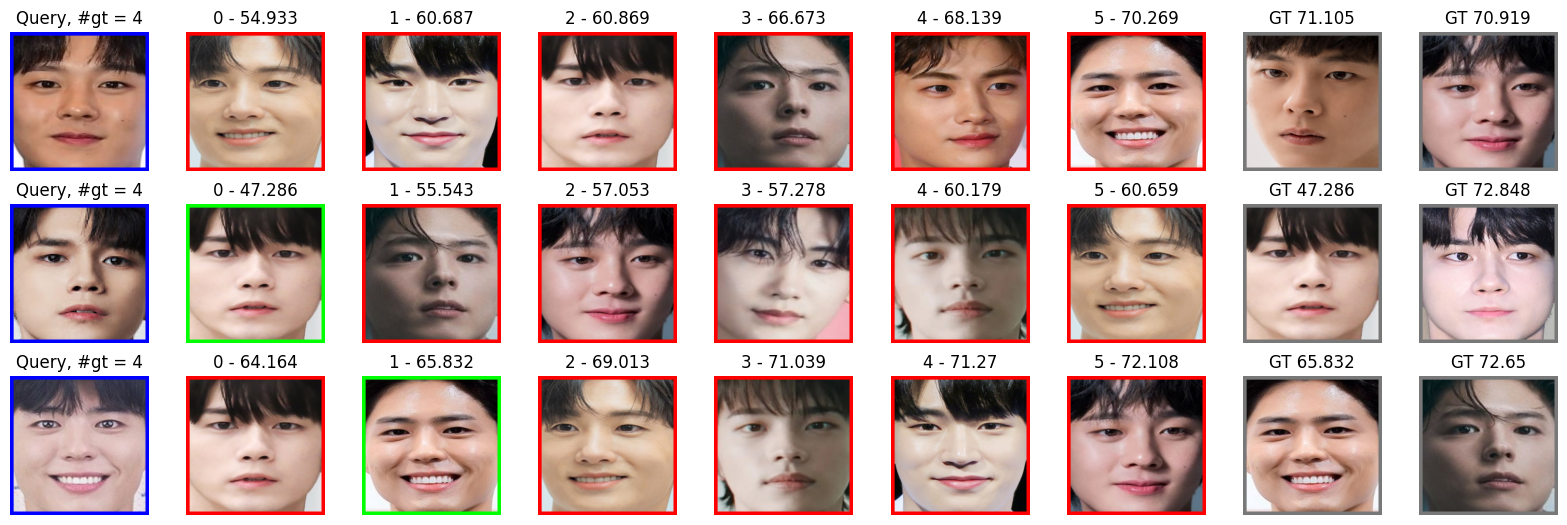

In [20]:
import matplotlib.pyplot as plt

# Visualisation
print("Draw predictions for predefined queries")
calculator.get_plot_for_queries(query_ids=[0, 1, 2], n_instances=6, verbose=False)
plt.show()



---
# STRI


In [21]:
from pprint import pprint

from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader

from oml.miners.pairs import PairsMiner
from oml.models import ConcatSiamese
from oml.retrieval.postprocessors.pairwise import PairwiseImagesPostprocessor

In [22]:
# Let's start with saving embeddings of a pretrained extractor for which we want to build a postprocessor

extractor = ViTExtractor("vits16_dino", arch="vits16", normalise_features=False)
transform = get_normalisation_resize_torch(im_size=64)

embeddings_train, embeddings_val, df_train, df_val = \
    inference_on_dataframe(dataset_root, "/OML/img/df.csv", extractor=extractor, transforms=transform)

# We are building Siamese model on top of existing weights and train it to recognize positive/negative pairs
siamese = ConcatSiamese(extractor=extractor, mlp_hidden_dims=[100])
optimizer = torch.optim.SGD(siamese.parameters(), lr=1e-6)
miner = PairsMiner(hard_mining=True)
criterion = BCEWithLogitsLoss()

train_dataset = DatasetWithLabels(df=df_train, transform=transform, extra_data={"embeddings": embeddings_train})
batch_sampler = BalanceSampler(train_dataset.get_labels(), n_labels=2, n_instances=2)
train_loader = DataLoader(train_dataset, batch_sampler=batch_sampler)

for batch in train_loader:
    # We sample pairs on which the original model struggled most
    ids1, ids2, is_negative_pair = miner.sample(features=batch["embeddings"], labels=batch["labels"])
    probs = siamese(x1=batch["input_tensors"][ids1], x2=batch["input_tensors"][ids2])
    loss = criterion(probs, is_negative_pair.float())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

# Siamese re-ranks top-n retrieval outputs of the original model performing inference on pairs (query, output_i)
val_dataset = DatasetQueryGallery(df=df_val, extra_data={"embeddings": embeddings_val}, transform=transform)
valid_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

postprocessor = PairwiseImagesPostprocessor(top_n=3, pairwise_model=siamese, transforms=transform)
calculator = EmbeddingMetrics(postprocessor=postprocessor)
calculator.setup(num_samples=len(val_dataset))

for batch in valid_loader:
    calculator.update_data(data_dict=batch)

pprint(calculator.compute_metrics())  # Pairwise inference happens here

https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth
Checkpoint is already here.


cpu:   0%|          | 0/1 [00:00<?, ?it/s]


Postprocessor's inference has been started...


cpu:   0%|          | 0/1 [00:00<?, ?it/s]


Metrics:
{'OVERALL': {'cmc': {5: tensor(0.5000)},
             'map': {5: tensor(0.2750)},
             'pcf': {0.5: tensor(0.0182)},
             'precision': {5: tensor(0.1875)}}}
{'OVERALL': {'cmc': {5: tensor(0.5000)},
             'map': {5: tensor(0.2750)},
             'pcf': {0.5: tensor(0.0182)},
             'precision': {5: tensor(0.1875)}}}


In [24]:
from oml.const import PATHS_COLUMN
from oml.registry.transforms import get_transforms_for_pretrained
from oml.retrieval.postprocessors.pairwise import PairwiseImagesPostprocessor
from oml.utils.misc_torch import pairwise_dist

# 1. Let's use feature extractor to get predictions
extractor = ViTExtractor.from_pretrained("vits16_dino")
transforms, _ = get_transforms_for_pretrained("vits16_dino")

_, emb_val, _, df_val = inference_on_dataframe(dataset_root, "/OML/img/df.csv", extractor, transforms=transforms)

is_query = df_val["is_query"].astype('bool').values
distances = pairwise_dist(x1=emb_val[is_query], x2=emb_val[~is_query])

print("\nOriginal predictions:\n", torch.topk(distances, dim=1, k=3, largest=False)[1])

# 2. Let's initialise a random pairwise postprocessor to perform re-ranking
siamese = ConcatSiamese(extractor=extractor, mlp_hidden_dims=[100])  # Note! Replace it with your trained postprocessor
postprocessor = PairwiseImagesPostprocessor(top_n=3, pairwise_model=siamese, transforms=transforms)

dataset = DatasetQueryGallery(df_val, extra_data={"embeddings": emb_val}, transform=transforms)
loader = DataLoader(dataset, batch_size=4)

query_paths = df_val[PATHS_COLUMN][is_query].values
gallery_paths = df_val[PATHS_COLUMN][~is_query].values
distances_upd = postprocessor.process(distances=distances, queries=query_paths, galleries=gallery_paths)

print("\nPredictions after postprocessing:\n", torch.topk(distances_upd, dim=1, k=3, largest=False)[1])

https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth
Checkpoint is already here.


cpu:   0%|          | 0/1 [00:00<?, ?it/s]


Original predictions:
 tensor([[ 4, 15,  8],
        [ 4, 15,  1],
        [ 8, 15,  4],
        [15,  1, 24],
        [ 4,  1, 14],
        [25, 14,  6],
        [ 4, 15,  0],
        [28, 14,  1]])

Postprocessor's inference has been started...


cpu:   0%|          | 0/1 [00:00<?, ?it/s]


Predictions after postprocessing:
 tensor([[ 4, 15,  8],
        [ 1,  4, 15],
        [15,  4,  8],
        [ 1, 24, 15],
        [ 1, 14,  4],
        [ 6, 14, 25],
        [ 0,  4, 15],
        [28,  1, 14]])


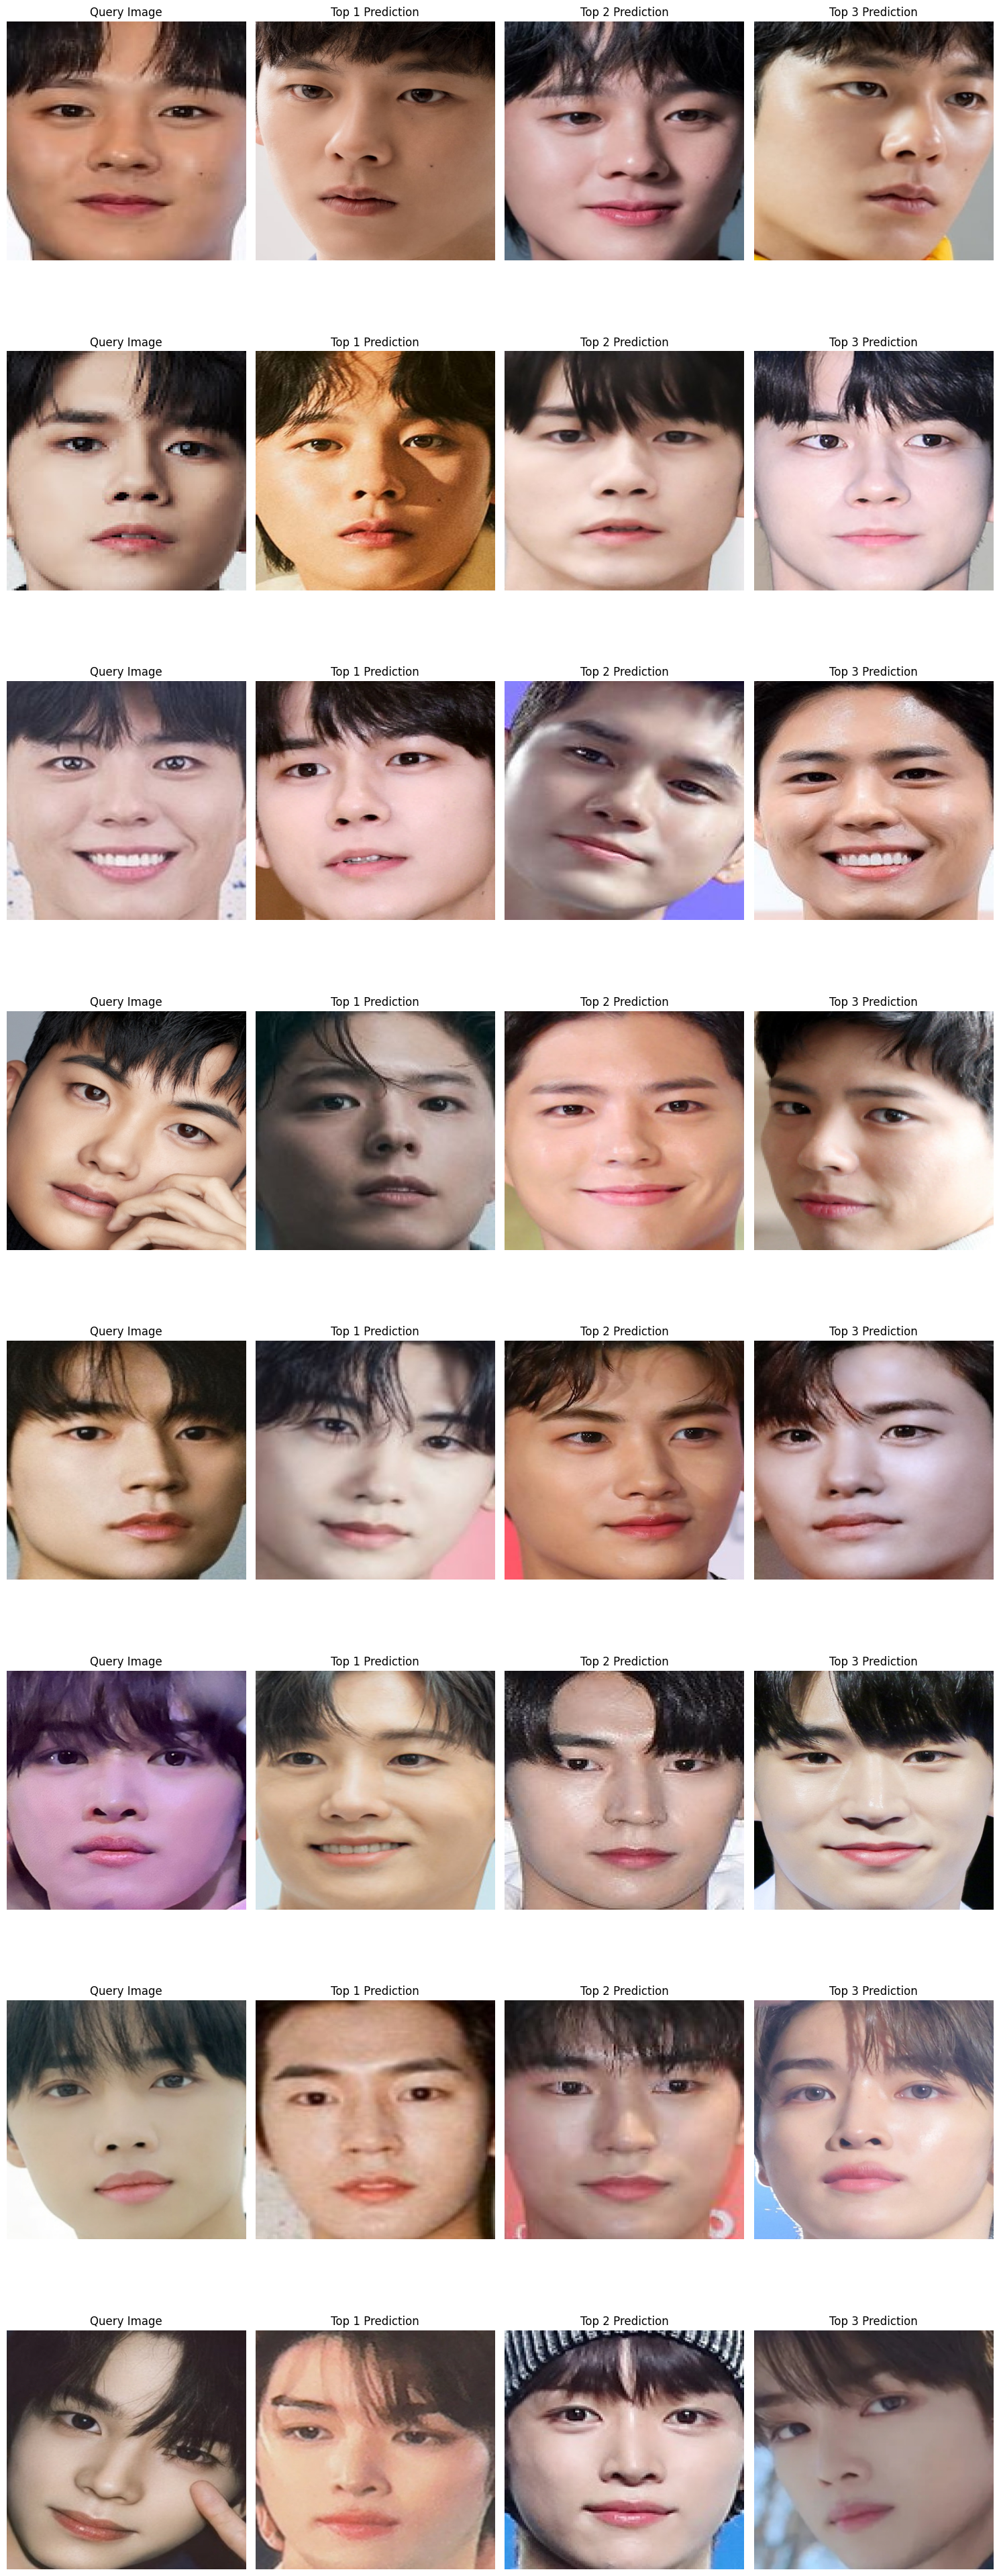

In [39]:
import cv2

def visualize_predictions(query_paths, gallery_paths, distances, top_k=3):
    num_queries = len(query_paths)
    fig, axes = plt.subplots(num_queries, top_k + 1, figsize=(15, 5*num_queries))
    query_paths = df_val[PATHS_COLUMN][is_query].values.astype(str)
    gallery_paths = df_val[PATHS_COLUMN][~is_query].values.astype(str)
    for i in range(num_queries):
        query_img = cv2.imread(query_paths[i])
        query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)
        axes[i, 0].imshow(query_img)
        axes[i, 0].set_title("Query Image")
        axes[i, 0].axis('off')

        gallery_paths_for_query = [gallery_paths[i * top_k + j] for j in range(top_k)]
        for j, gallery_path in enumerate(gallery_paths_for_query):
            pred_img = cv2.imread(gallery_path)
            pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)
            axes[i, j+1].imshow(pred_img)
            axes[i, j+1].set_title(f"Top {j+1} Prediction")
            axes[i, j+1].axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(query_paths, gallery_paths, distances_upd)